# Tutorial for geometry.py

This notebook will introduce the core functionalities of the geometry.py class. The geometry.py module allows you to manipulate geometry file types of typical DFT codes. It has a focus on surface geometries.

First we load the necessary dependecies:

In [1]:
from dfttools import geometry

Next, we load a geometry and print the coordinates of the atoms in it. We are loading an AIMS-geometry, so we use the AimsGeometry class. There are also VaspGeometry and XYZGeometry classes.

In [2]:
geom = geometry.AimsGeometry('data/bulk_substrate.in')

print(geom.coords)

[[0. 0. 0.]]


Let us now visualise the geoemtry. The visualise function has *many* keyword parameters, all of which are very useful. But for a quick overview you don't need them. We will introduce some of them later on.

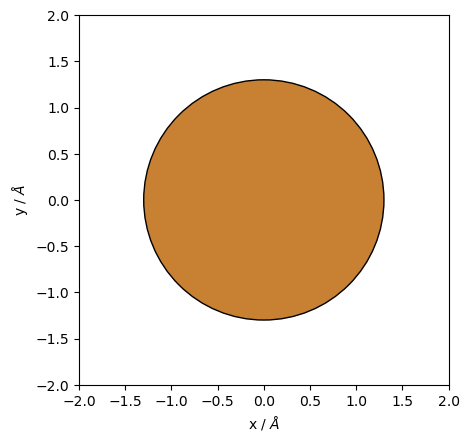

In [3]:
geom.visualise()

It turns out we loaded a single copper atom. We loaded a bulk unit cell of copper, containing a single atom. Let's make a lager patch of copper atoms using the periodica replica function.

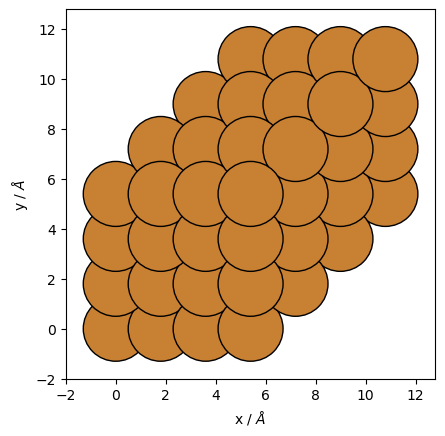

In [4]:
geom_rep = geom.get_periodic_replica((4,4,4))
geom_rep.visualise()

Great! We now have a patch of copper atoms. The <code>geom.get_periodic_replica</code> function also replicates the lattice vectors and any other atom-wise property.

Let us now create a (111)-surface slab.

[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]


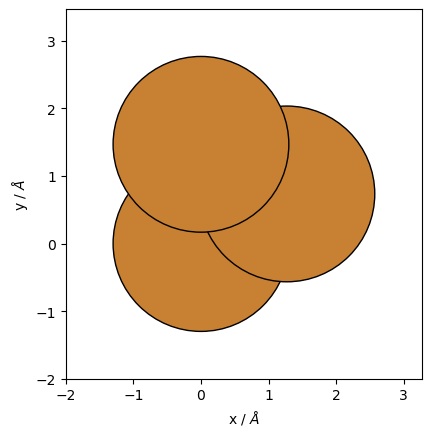

In [6]:
geom_surf = geom.get_primitive_slab((1, 1, 1))
geom_surf.visualise()

The visualise function can look at the structure from different angles using the <code>axes</code> keyword. It takes a tuple as input, where the two integers indicate the axes. We will look at the x and z-axes.

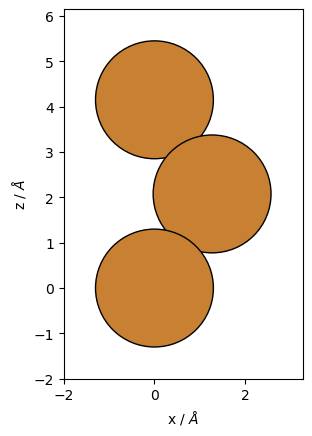

In [7]:
geom_surf.visualise(axes=[0,2])

Now we have a slab, containing three layers. Let us replicate it with the <code>geom.get_periodic_replica</code> function to get a surface unit cell. Note that we replicate 8 times in x, 8 times in y and only 1 time in z direction. I.e. we just keep our 3 layers in z-direction.

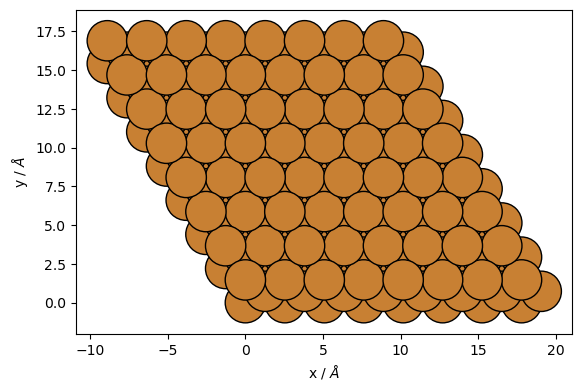

In [9]:
geom_surf_rep = geom_surf.get_periodic_replica((8,8,1))
geom_surf_rep.visualise()